In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path
from easydict import EasyDict

import torch
import torch.nn as nn
from tqdm import tqdm
import random
import igl

try:
    from matplotrender import *
except:
    !pip install git+https://github.com/chacorp/matplotrender.git
    from matplotrender import *
from utils.util import *

C:\Users\SihunCha\AppData\Roaming\Python\Python37\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# MVC 3D

## utils

In [2]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    
cmap=plt.get_cmap("rainbow")
def show_gird_weight(img, src_cage, show_grid, col=2):
    fig1 = plt.figure(figsize=(22, 6))
    HW = show_grid.shape[-1]
    W = int(np.ceil(HW / col))
    for i in range(HW):
        plot_num = col*100+W*10+(i+1)
        ax1 = fig1.add_subplot(plot_num)
        im1 = ax1.imshow(show_grid[...,i].reshape(img.shape[0], img.shape[1], -1), cmap=cmap)
        ax1.plot(np.r_[src_cage[:,0], src_cage[0,0]], np.r_[src_cage[:,1], src_cage[0,1]], '-o')
        cbar = fig1.colorbar(im1, ax=ax1, fraction=0.035, pad=0.02)
        cbar.minorticks_on()


In [3]:
def make_box_cage(v_min=(-1.0, -1.5, -1.0), v_max=(1.0, 1.5, 1.0)):
    """
    Y-up, RH. 
    v indices:
      0:(+x,+y,+z) 1:(+x,+y,-z) 2:(-x,+y,+z) 3:(-x,+y,-z)
      4:(+x,-y,+z) 5:(+x,-y,-z) 6:(-x,-y,+z) 7:(-x,-y,-z)
    """
    xM, yM, zM = v_max
    xm, ym, zm = v_min

    v = np.array([
        [xM, yM, zM],  # 0
        [xM, yM, zm],  # 1
        [xm, yM, zM],  # 2
        [xm, yM, zm],  # 3
        [xM, ym, zM],  # 4
        [xM, ym, zm],  # 5
        [xm, ym, zM],  # 6
        [xm, ym, zm],  # 7
    ], dtype=float)

    qf = np.array([
        [0, 1, 3, 2],  # +Y (top)
        [4, 6, 7, 5],  # -Y (bottom)
        [0, 4, 5, 1],  # +X (right)
        [2, 3, 7, 6],  # -X (left)
        [0, 2, 6, 4],  # +Z (front)
        [1, 5, 7, 3],  # -Z (back)
    ], dtype=int)

    # Triangulate each quad: [a,b,c], [a,c,d]
    tri1 = qf[:, [0, 1, 2]]
    tri2 = qf[:, [0, 2, 3]]
    f = np.vstack([tri1, tri2])

    cage = EasyDict(v=v, qf=qf, f=f)
    return cage

def make_plane_cage(v_min=(-1.0, -1.5, -1.0), v_max=(1.0, 1.5, 1.0)):
    """
    Y-up, RH. 
    v indices:
      0:(+x,+y,+z) 1:(+x,+y,-z) 2:(-x,+y,+z) 3:(-x,+y,-z)
      4:(+x,-y,+z) 5:(+x,-y,-z) 6:(-x,-y,+z) 7:(-x,-y,-z)
    """
    xM, yM, zM = v_max
    xm, ym, zm = v_min

    v = np.array([
        [xM, yM, zM],  # 0
        [xM, yM, zm],  # 1
        [xm, yM, zM],  # 2
        [xm, yM, zm],  # 3
        [xM, ym, zM],  # 4
        [xM, ym, zm],  # 5
        [xm, ym, zM],  # 6
        [xm, ym, zm],  # 7
    ], dtype=float)

    qf = np.array([
        # [0, 1, 3, 2],  # +Y (top)
        # [4, 6, 7, 5],  # -Y (bottom)
        [0,4,7,3],
        # [0, 4, 5, 1],  # +X (right)
        # [2, 3, 7, 6],  # -X (left)
        # [0, 2, 6, 4],  # +Z (front)
        # [1, 5, 7, 3],  # -Z (back)
    ], dtype=int)

    # Triangulate each quad: [a,b,c], [a,c,d]
    tri1 = qf[:, [0, 1, 2]]
    tri2 = qf[:, [0, 2, 3]]
    f = np.vstack([tri1, tri2])

    # Wireframe edges (12)
    # e = np.array([
    #     [0,1],[1,3],[3,2],[2,0],  # top loop (+Y)
    #     [4,5],[5,7],[7,6],[6,4],  # bottom loop (-Y)
    #     [0,4],[1,5],[2,6],[3,7],  # verticals
    # ], dtype=int)

    # cage = EasyDict(v=v, qf=qf, f=f, e=e)
    cage = EasyDict(v=v, qf=qf, f=f)
    return cage

# Learning MVC from data
Obtain cage weights using Neural Network (simple MLP)

In [4]:
class MLP(nn.Module):
    def __init__(self, in_dim=2, out_dim=2, hid_dim=64, is_w=False, pou=False):
        super().__init__()
        self.fc1 = nn.Linear(in_dim, hid_dim)
        self.fc2 = nn.Linear(hid_dim, hid_dim)
        self.fc3 = nn.Linear(hid_dim, hid_dim)
        self.fc4 = nn.Linear(hid_dim, hid_dim)
        self.fc5 = nn.Linear(hid_dim, hid_dim)
        self.fc6 = nn.Linear(hid_dim, hid_dim)
        
        self.fc_out = nn.Linear(hid_dim, out_dim)
        self.act = nn.LeakyReLU(0.2)
        
        self.pou = pou
        self.is_w = is_w
        # if self.is_w:
        #     self.m_out = nn.Linear(hid_dim, out_dim)
        
    def forward(self, x_in, pou=False):
        """
        Args:
            x_in (torch.tensor): (B,N,in_dim)
        Returns
            out: (B,N,out_dim)
        """
        out1 = self.act(self.fc1(x_in))
        out2 = self.act(self.fc2(out1))
        out3 = self.act(self.fc3(out2))
        out4 = self.act(self.fc4(out3))
        out5 = self.act(self.fc5(out4))
        out6 = self.act(self.fc6(out5))
        
        out = self.fc_out(out6)
        
        if self.is_w:
            # out = out * torch.nn.Sigmoid()(self.m_out(out6)*10.0)
            # out = torch.nn.functional.normalize(out, dim=-2) # too much warping...
            
            # out = torch.nn.Sigmoid()(out)
            # out = torch.nn.Softplus()(out) # --- ripped ..!!
            # out = self.act(out) # -------------- ripped ...!!!
            # out = torch.nn.ELU(alpha=1.0)(out)
            out = torch.nn.ELU(alpha=0.5)(out)
            # out = torch.nn.ELU(alpha=0.3)(out)
            # out = torch.nn.ELU(alpha=0.1)(out)
            # out = torch.nn.ELU(alpha=0.05)(out)
            # out = torch.nn.LeakyReLU(0.2)(out)
            # out = out / (out.sum(dim=-1, keepdim=True)+1e-12) ## cause boundary collapse
            
        if self.pou:
            out = out / (out.sum(dim=-1, keepdim=True)+1e-12) ## cause boundary collapse
            
        return out

# 3d case

In [10]:


v_max = np.array([1.0, 1.5, 1.0])
v_min = -1 * v_max

# large cube cage
control_mesh = make_box_cage(v_min=v_min, v_max=v_max)

# deformed cage
control_mesh_v2 = control_mesh.v.copy()
control_mesh_v2[0:4, 0] = control_mesh_v2[0:4, 0]+0.8


# deformed cage
control_mesh_v3 = control_mesh.v.copy()
control_mesh_v3[0:4, 1] = control_mesh_v3[0:4, 1]+0.5


# deformed cage
control_mesh_v4 = control_mesh.v.copy()
control_mesh_v4[0:4, 1] = control_mesh_v4[0:4, 1]-0.5
control_mesh_v4[4:8, 0] = control_mesh_v4[4:8, 0] * 2
control_mesh_v4[4:8, 2] = control_mesh_v4[4:8, 2] * 2


# deformed cage
control_mesh_v5 = control_mesh.v.copy()
control_mesh_v5 = apply_transform(control_mesh_v5, z_rotation(50))
control_mesh_v5 = apply_transform(control_mesh_v5, y_rotation(30))

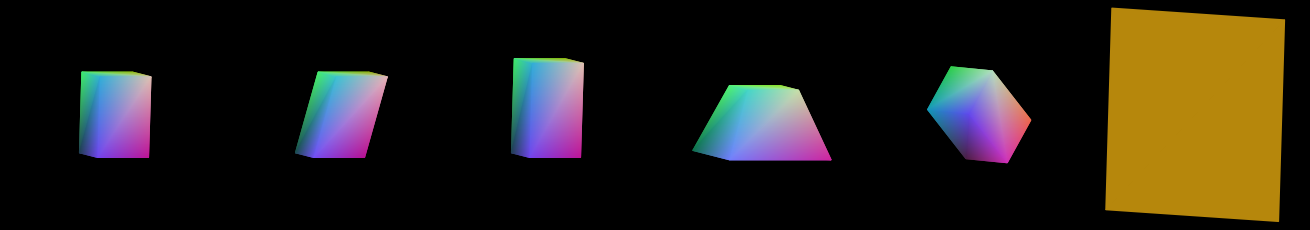

In [11]:
# figure size
SIZE = 3
mesh_scale = .25

scalar = 2.5
plane_cage = make_plane_cage(v_min=v_min*scalar, v_max=v_max*scalar)

v_list=[control_mesh.v, control_mesh_v2, control_mesh_v3, control_mesh_v4, control_mesh_v5, plane_cage.v]
f_list=[control_mesh.f, control_mesh.f, control_mesh.f, control_mesh.f, control_mesh.f, plane_cage.f]

# xyz Euler angle to rotate the mesh
rot_list=[ [5,20,0] ]*len(v_list)

plot_mesh_gouraud(v_list, f_list, 
                     # is_diff=True, diff_base=src_mesh.v, #diff_revert=True,
                     mesh_scale=mesh_scale,
                     rot_list=rot_list, size=SIZE, mode='normal')

In [12]:
src_mesh = EasyDict()
src_mesh.v, src_mesh.f = igl.read_triangle_mesh("data/source_restpose_mesh.obj")
print('Loaded mesh')
print('\t src vertices:', src_mesh.v.shape, '\t faces:', src_mesh.f.shape) # (11248, 3) (22288, 3)


Loaded mesh
	 src vertices: (11248, 3) 	 faces: (22288, 3)


In [21]:
set_seed(42)


mesh_tgt = src_mesh.v
mesh_tgt_th = torch.tensor(mesh_tgt)[None].float()
NV = mesh_tgt_th.shape[1]


src_cage = control_mesh.v
src_cage_th = torch.tensor(src_cage).float()
deform_th = torch.tensor(control_mesh_v4).float()
deform_th2 = torch.tensor(control_mesh_v5).float()

CC = src_cage_th.shape[0]
NC = src_cage_th.reshape(-1).shape[0]

model2 = MLP(in_dim=3+NC, out_dim=src_cage.shape[0], pou=True, is_w=True)
optimizer2 = torch.optim.Adam([*model2.parameters()], lr=5e-4)


model2.train()


src_in = torch.cat([mesh_tgt_th, src_cage_th.reshape(1,1,-1).repeat(1,NV,1)], dim=-1).float()
cage_in = torch.cat([src_cage_th[None], src_cage_th.reshape(1,1,-1).repeat(1,CC,1)], dim=-1).float()



LW = 1/4

for i in tqdm(range(25_000)):
    optimizer2.zero_grad()
    
    loss=0
    # pred_mesh_W = model2(src_in)    
    # pred_mesh_tgt = pred_mesh_W @ src_cage_th    
    # loss += torch.nn.L1Loss()(mesh_tgt_th, pred_mesh_tgt) * LW # linear precision
        
    ### ------------------------ lagrange property -----------------------
    pred_cage_W = model2(cage_in)
    # loss += torch.nn.L1Loss()(torch.eye(CC)[None], pred_cage_W) * LW ## somehow gives strange result
    
    pred_cage_th = pred_cage_W @ src_cage_th
    pred_cage_th_deform = pred_cage_W @ deform_th
    
    loss += torch.nn.L1Loss()(src_cage_th[None], pred_cage_th) * LW
    loss += torch.nn.L1Loss()(deform_th[None], pred_cage_th_deform) * LW
    ### ------------------------------------------------------------------
    
    ### grid -------------------------------------------------------------
    _sample = 128    
    ## random points from in and out grid
    # grid_th_ = torch.randint(-10, MX+10, (1, _sample,2))*1.0
    grid_th_ = torch.randn((1, _sample, 3)) * v_max * 2
    
    
    grid_in = torch.cat([grid_th_, src_cage_th.reshape(1,1,-1).repeat(1,_sample,1)], dim=-1).float()
    pred_grid_W = model2(grid_in)
    pred_grid_th = pred_grid_W @ src_cage_th
    loss += torch.nn.L1Loss()(grid_th_, pred_grid_th) * LW
    ### ------------------------------------------------------------------
    
    ### partition of unity -----------------------------------------------
    # loss += torch.nn.L1Loss()(torch.ones(1,NV), pred_mesh_W.sum(-1)) * LW * 0.1
    # loss += torch.nn.L1Loss()(torch.ones(1,_sample), pred_grid_W.sum(-1)) * LW * 0.1
    # loss += torch.nn.L1Loss()(torch.ones(1,CC), pred_cage_W.sum(-1)) * LW * 0.1
    ### ------------------------------------------------------------------
    
    
    loss.backward()
    optimizer2.step()
    if i % 2000==0:
        print(i, loss.item())


torch.Size([1, 11248, 27]) torch.Size([1, 8, 27]) 24


  0%|          | 0/25000 [00:00<?, ?it/s]

  0%|          | 20/25000 [00:00<02:08, 194.70it/s]

0 1.1680186986923218


  8%|▊         | 2033/25000 [00:10<01:52, 204.61it/s]

2000 0.028826141729950905


 16%|█▌        | 4018/25000 [00:19<01:45, 198.77it/s]

4000 0.01622750237584114


 24%|██▍       | 6034/25000 [00:29<01:33, 203.12it/s]

6000 0.013113165274262428


 32%|███▏      | 8034/25000 [00:39<01:24, 200.54it/s]

8000 0.013743757270276546


 40%|████      | 10025/25000 [00:48<01:14, 201.34it/s]

10000 0.013354477472603321


 48%|████▊     | 12028/25000 [00:58<00:59, 217.35it/s]

12000 0.01470545120537281


 56%|█████▌    | 14026/25000 [01:07<00:51, 214.25it/s]

14000 0.014090223237872124


 64%|██████▍   | 16021/25000 [01:17<00:41, 215.99it/s]

16000 0.01725640334188938


 72%|███████▏  | 18023/25000 [01:27<00:33, 210.83it/s]

18000 0.009037943556904793


 80%|████████  | 20026/25000 [01:36<00:22, 216.34it/s]

20000 0.009398173540830612


 88%|████████▊ | 22039/25000 [01:46<00:13, 213.08it/s]

22000 0.01487887091934681


 96%|█████████▌| 24037/25000 [01:55<00:04, 196.75it/s]

24000 0.015217303298413754


100%|██████████| 25000/25000 [02:00<00:00, 207.77it/s]


## slice coordinate space and visualize

(16384, 3)
(16384,)
(128, 128, 3)


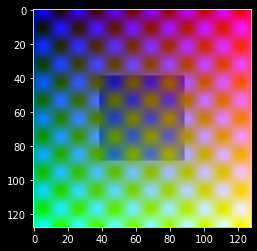

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


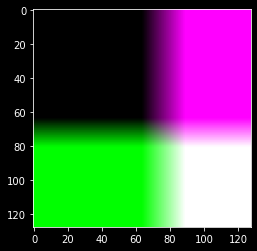

False True


In [ ]:
X_v, Y_v, Z_v = plane_cage.v[:,0], plane_cage.v[:,1], plane_cage.v[:,2]

## sample points in space
HW = 128
X_coord, Y_coord = np.meshgrid(
    np.linspace(X_v.min(), X_v.max(), HW),
    np.linspace(Y_v.min(), Y_v.max(), HW),
)
XYZ_margin = np.stack([X_coord.ravel(), Y_coord.ravel(), X_coord.ravel()], axis=1)
# XYZ_margin = np.stack([Y_coord.ravel(), X_coord.ravel(), Y_coord.ravel()], axis=1)
print(XYZ_margin.shape)

# path = Path(plane_cage.v[:,:2]/scalar)
# inside = path.contains_points(XYZ_margin[:,[0,1]])
# inside_x_max = np.where(XYZ_margin[:,0] < v_max[0], True, False)
# inside_y_max = np.where(XYZ_margin[:,1] < v_max[1], True, False)
# inside_x_min = np.where(XYZ_margin[:,0] > v_min[0], True, False)
# inside_y_min = np.where(XYZ_margin[:,1] > v_min[1], True, False)
# inside =  inside_x_max & inside_x_min & inside_y_max & inside_y_min
inside = np.all((XYZ_margin[:, :2] > v_min[:2]) & (XYZ_margin[:, :2] < v_max[:2]), axis=1)
print(inside.shape)


## color for visualization
grid_intv=12
yy, xx = np.meshgrid(np.linspace(0,1,HW), np.linspace(0,1,HW), indexing='ij')

aa = np.tile(np.linspace(0,1,HW), HW)
bb = np.linspace(0,1,HW).repeat(HW)
pv = np.c_[aa, bb]

img = np.zeros((HW, HW, 3), dtype=np.float32)
img[...,0] = xx
img[...,1] = yy
img[...,2] = (np.sin(grid_intv*np.pi*xx)*np.cos(grid_intv*np.pi*yy)+1) * 0.5
img.reshape(-1,3)[inside,0] -= img.reshape(-1,3)[inside,2] *0.25
img.reshape(-1,3)[inside,1] -= img.reshape(-1,3)[inside,2] *0.25
img.reshape(-1,3)[inside,2] -= img.reshape(-1,3)[inside,2] *0.25
# img[...,0] -= img[...,2] *0.25
# img[...,1] -= img[...,2] *0.25
print(img.shape)

plt.imshow(img)
plt.show()
plt.imshow(XYZ_margin.reshape(HW,HW,-1))
plt.show()


def make_triangle(pv, margin=0.1):
    triangles = []
    index_map = {tuple(p): i for i, p in enumerate(pv)}

    for i, p in enumerate(pv):
        x, y = p
        right = (x + margin, y)
        up = (x, y + margin)
        diag = (x + margin, y + margin)
        
        if right in index_map and up in index_map and diag in index_map:
            a = i
            b = index_map[right]
            c = index_map[diag]
            d = index_map[up]
            
            triangles.append([a, b, c])
            triangles.append([a, c, d])

    triangles = np.array(triangles)
    return triangles

# ## triangulate grid
triangles = make_triangle(pv, aa[1])

# ## visualize
# triang = tri.Triangulation(pv[:, 0], pv[:, 1], triangles)

# plt.figure(figsize=(15,15))
# plt.triplot(triang, color='gray', linewidth=.01)
# plt.plot(pv[:, 0], pv[:, 1], '.')
# plt.gca().set_aspect('equal')
# plt.title("Triangles and Vertex Indices")
# plt.show()

print(inside.min(), inside.max())

In [23]:
img_inside = img.copy()

model2.eval()

src_in = torch.cat([
    mesh_tgt_th,
    src_cage_th.reshape(1,1,-1).repeat(1,NV,1)
], dim=-1)
src_in_g = torch.cat([
    torch.tensor(XYZ_margin[None]).float(),
    src_cage_th.reshape(1,1,-1).repeat(1,XYZ_margin.shape[0],1)
], dim=-1)

deform2 = control_mesh_v2
deform4 = control_mesh_v4
deform5 = control_mesh_v5

with torch.no_grad():
    pred_mesh2_W = model2(src_in).detach().cpu().numpy().squeeze()
    pred_grid2_W = model2(src_in_g).detach().cpu().numpy().squeeze()
    
    pred_mesh2_src = pred_mesh2_W @ src_cage
    pred_mesh2_def2 = pred_mesh2_W @ deform2
    pred_mesh2_def4 = pred_mesh2_W @ deform4
    pred_mesh2_def5 = pred_mesh2_W @ deform5
    
    pred_grid2_src = pred_grid2_W @ src_cage
    pred_grid2_def2 = pred_grid2_W @ deform2
    pred_grid2_def4 = pred_grid2_W @ deform4
    pred_grid2_def5 = pred_grid2_W @ deform5
    

C = cage
       GT       | recon w/ init C |    init C    | deformed mesh 1 | deformed C 1 | deformed mesh 2 | deformed C 2


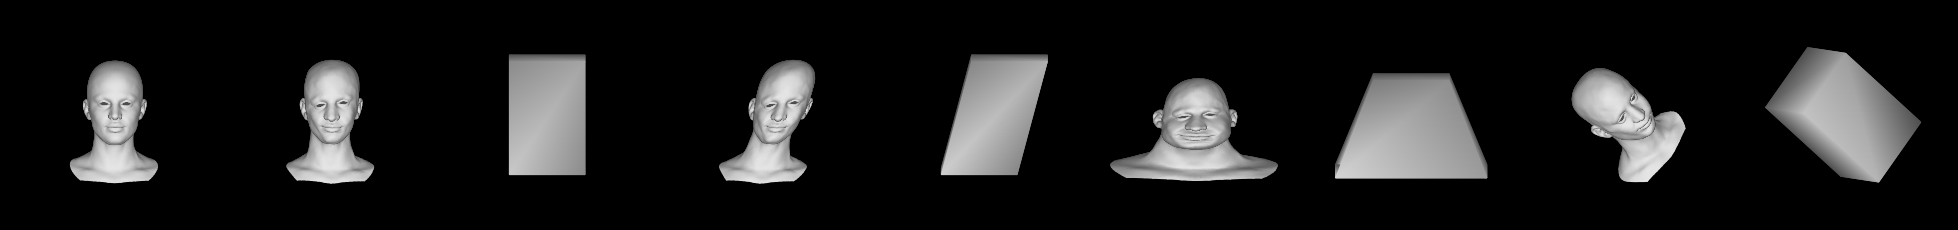

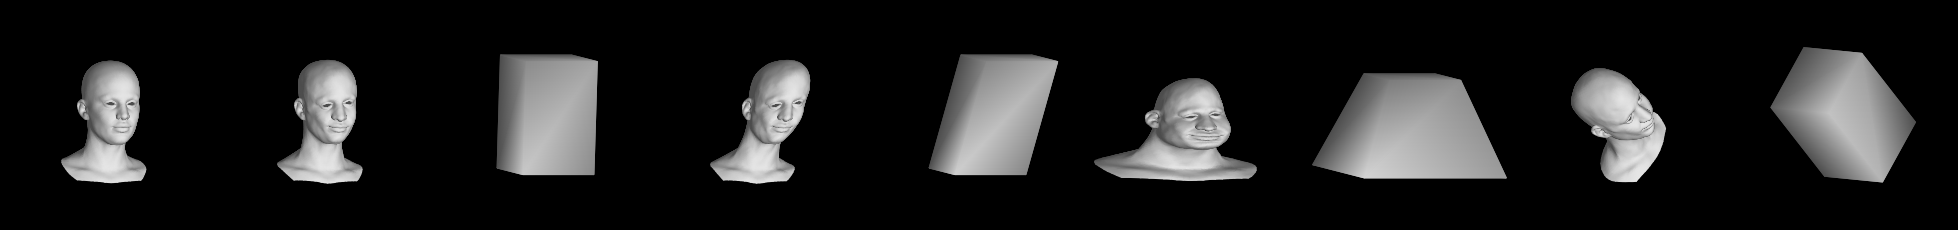

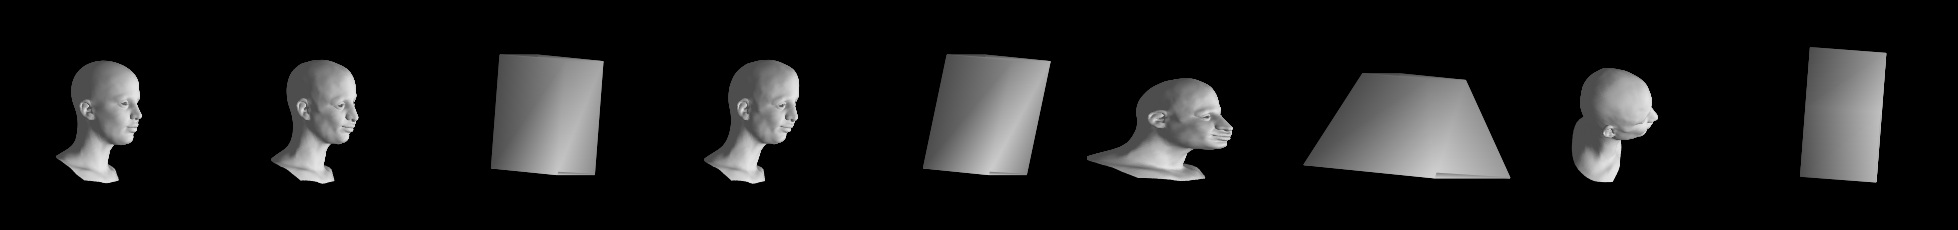

In [24]:
from matplotrender import *
# figure size
SIZE = 3
mesh_scale = .35

# v_list=[ pred_mesh2_src, control_mesh.v, control_mesh_v2, control_mesh_v4, XYZ_margin]
# v_list=[ pred_mesh2_def2, control_mesh.v, control_mesh_v2, control_mesh_v4, XYZ_margin]
# v_list=[ pred_mesh2_def4, control_mesh.v, control_mesh_v2, control_mesh_v4]
# f_list=[ src_mesh.f, control_mesh.f, control_mesh.f, control_mesh.f]
v_list=[ mesh_tgt, pred_mesh2_src, control_mesh.v, pred_mesh2_def2, control_mesh_v2, pred_mesh2_def4, control_mesh_v4, pred_mesh2_def5, control_mesh_v5]
f_list=[ src_mesh.f, src_mesh.f, control_mesh.f, src_mesh.f, control_mesh.f, src_mesh.f, control_mesh.f, src_mesh.f, control_mesh.f]

print('C = cage')
print('       GT       | recon w/ init C |    init C    | deformed mesh 1 | deformed C 1 | deformed mesh 2 | deformed C 2')
# xyz Euler angle to rotate the mesh
rot_list=[ [5,0,0] ]*len(v_list)
plot_mesh_gouraud(v_list, f_list, 
                     # is_diff=True, diff_base=src_mesh.v, #diff_revert=True,
                     mesh_scale=mesh_scale,
                     rot_list=rot_list, size=SIZE, mode='shade')

rot_list=[ [5,20,0] ]*len(v_list)
plot_mesh_gouraud(v_list, f_list, 
                     # is_diff=True, diff_base=src_mesh.v, #diff_revert=True,
                     mesh_scale=mesh_scale,
                     rot_list=rot_list, size=SIZE, mode='shade')

rot_list=[ [5,60,0] ]*len(v_list)
plot_mesh_gouraud(v_list, f_list, 
                     # is_diff=True, diff_base=src_mesh.v, #diff_revert=True,
                     mesh_scale=mesh_scale,
                     rot_list=rot_list, size=SIZE, mode='shade')


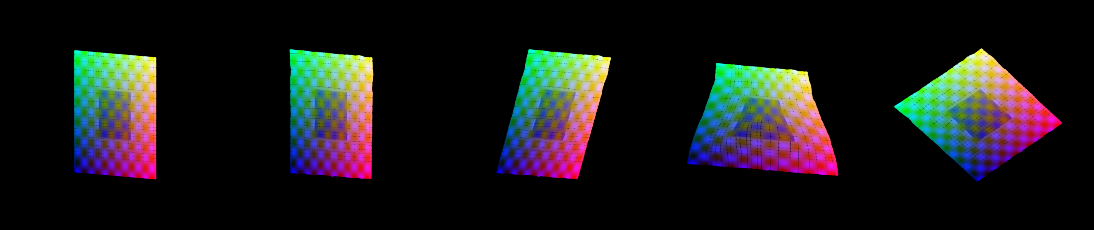

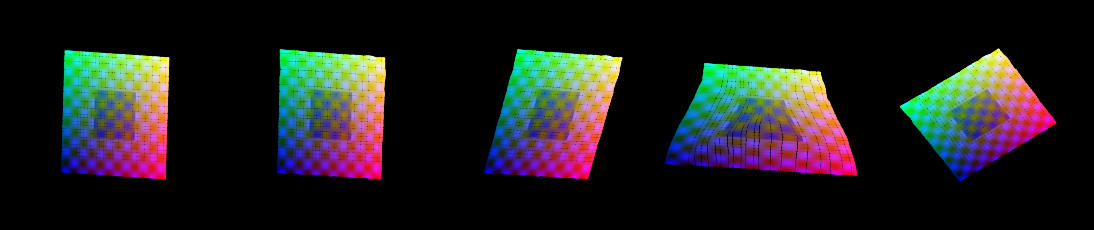

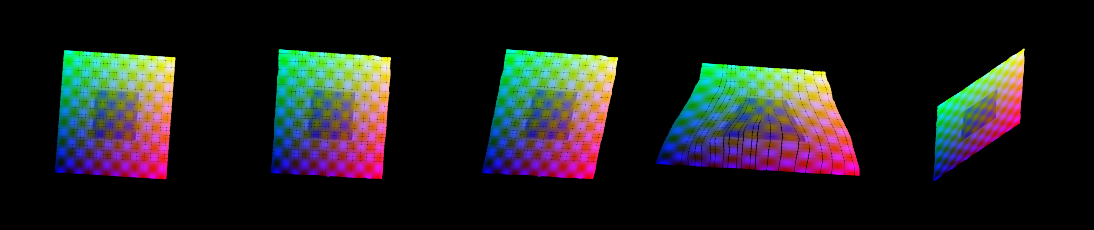

In [25]:

SIZE = 3
mesh_scale = .15

v_list=[ XYZ_margin, pred_grid2_src, pred_grid2_def2, pred_grid2_def4, pred_grid2_def5]
f_list=[ triangles, triangles, triangles, triangles, triangles]
c_list=[ img.reshape(-1,3), img.reshape(-1,3), img.reshape(-1,3), img.reshape(-1,3), img.reshape(-1,3)]

# xyz Euler angle to rotate the mesh
rot_list=[ [5,0,0] ]*len(v_list)
plot_mesh_gouraud(v_list, f_list, c_list, is_color=True,
                     # is_diff=True, diff_base=src_mesh.v, #diff_revert=True,
                     mesh_scale=mesh_scale,
                     rot_list=rot_list, size=SIZE, mode='shade')

rot_list=[ [5,20,0] ]*len(v_list)
plot_mesh_gouraud(v_list, f_list, c_list, is_color=True,
                     # is_diff=True, diff_base=src_mesh.v, #diff_revert=True,
                     mesh_scale=mesh_scale,
                     rot_list=rot_list, size=SIZE, mode='shade')

rot_list=[ [5,60,0] ]*len(v_list)
plot_mesh_gouraud(v_list, f_list, c_list, is_color=True,
                     # is_diff=True, diff_base=src_mesh.v, #diff_revert=True,
                     mesh_scale=mesh_scale,
                     rot_list=rot_list, size=SIZE, mode='shade')